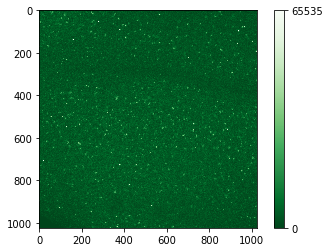

In [2]:
#!/usr/bin/env python

import sys
sys.path.insert(0,'/Users/cmdb/projects/ConfocalAnalysis')
from czifile import CziFile
import numpy as np
from math import sqrt
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import DBSCAN
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

with CziFile('/Users/babygirljohnston/Documents/Confocal_Xiuqi/Image_1.czi') as czi:
    image_arrays=czi.asarray()

#print image_arrays.shape[3]
# > (1, 4, 1, 26, 1024, 1024, 1)
# ?, channel, ?, z-stack, Y, X, ?
# most confocal pics we took are 16bit, == unit16
#print image_arrays





colomap=["Blues","gray","Greens_r","Reds_r"]
labell=['yellow','yellow','green','red']
## Extract Channel 1 -- Z-stack
channel=2
stack=5
# Images[stack#, Y, X]
images=[np.array(image_arrays[0,channel,0,index].T[0].T) for index in range(26)]
#print len(images)
# Show the map
fig=plt.figure()
mapp=plt.imshow(images[stack],cmap=colomap[channel])

cbar = fig.colorbar(mapp, ticks=[0, 65535])
cbar.ax.set_yticklabels(['0', '65535'])

plt.show()


In [6]:
## Identifying the blobs in a single plane
log = blob_log(images[stack], max_sigma=30, num_sigma=10, threshold=.15)

# Radius of the blob
log[:, 2] = log[:, 2] * sqrt(2)

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,10))

images=[np.array(image_arrays[0,1,0,index].T[0].T) for index in range(26)]
mapp=plt.imshow(images[stack],cmap=colomap[channel])

cbar = fig.colorbar(mapp, ticks=[0, 65535])
cbar.ax.set_yticklabels(['0', '65535'])

for blob in log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=labell[channel], linewidth=2, fill=False)   
    axes.add_patch(c)

plt.show()


NameError: name 'blob_log' is not defined

In [7]:
## plot blob radius & intensity distribution

print log.shape
hist, bin_edges=np.histogram(log[:,2],bins=40)
plt.subplot(3,1,1)
plt.bar(bin_edges[:-1],hist)
plt.xlim(0, 10)
plt.title('Radius')

## Histogram of Blob signal intensity
plt.subplot(3,1,2)
blob_intensity=np.zeros(len(log[:,0]))
for i in range(len(log[:,0])):
    blob_intensity[i]=images[stack][int(log[i,0]),int(log[i,1])]
#print len(log)
#print blob_intensity
hist, bin_edges=np.histogram(blob_intensity,bins=1000)
plt.bar(bin_edges[:-1],hist)
plt.xlim(0, 65535)
plt.title('Intensity')
plt.show()

# print log

## Histogram of overall signal intensity
plt.subplot(3,1,3)
hist, bin_edges=np.histogram(images[stack],bins=1000)
plt.bar(bin_edges[:-1],hist)
plt.xlim(0, 65535)
plt.show()

NameError: name 'log' is not defined

In [20]:
"""Spread out all stacks""" 
N_rows=6
N_cols=5
resolution=20
# Show the WHOLE Z-STACK
plt.figure(figsize = (resolution*N_cols,resolution*N_rows))
gs1 = gridspec.GridSpec(N_rows, N_cols)
gs1.update(wspace=0.05, hspace=0.05)

for i in range(26):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    image = images[i]
    plt.imshow(image,cmap=colomap[channel])
    ax1.set_aspect('equal')

plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
"""Spread out the stacks with blobs"""
N_rows=6
N_cols=5
resolution=20
# Show the WHOLE Z-STACK

#plt.figure(figsize = (resolution*N_cols,resolution*N_rows))
plt.figure(figsize = (5,5))

#gs1 = gridspec.GridSpec(N_rows, N_cols)
gs1 = gridspec.GridSpec(2, 2)

gs1.update(wspace=0.05, hspace=0.05)

for i in range(3):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    image = images[i]
    plt.imshow(image,cmap=colomap[channel])
    ax1.set_aspect('equal')
    log = blob_log(image, max_sigma=30, num_sigma=10, threshold=.2)
    log[:, 2] = log[:, 2] * sqrt(2)
    for blob in log:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=labell[channel], linewidth=2, fill=False)
        ax1.add_patch(c)
    #print log


In [137]:
"""Store all the blobs"""
blobsAll=[]
# [[[Y,X,Z1],...],[[Y,X,Z2],...],...,[[Y,X,Zn],...]],np.array

blobs={}
# "Y,X,Z"->[radius, intensity]

for z in range(6):
    planeblobs=[]
    ## Figure out the Blob dict data structure
    log = blob_log(images[z], max_sigma=30, num_sigma=10, threshold=.2)
    # Radius of the blob
    log[:, 2] = log[:, 2] * sqrt(2)
    # intensity
    blob_intensity=np.zeros(len(log[:,0]))
    for i in range(len(log[:,0])):
        blob_intensity[i]=images[z][int(log[i,0]),int(log[i,1])]
        
    for i in range(len(log[:,2])):
        position=np.append(log[i,0:2],z)
        position=map(int,position)
        blobs["{},{},{}".format(position[0],position[1],position[2])]=[log[i,2],blob_intensity[i]]
        planeblobs.append(position)
    blobsAll.append(planeblobs)

blobsAll=np.array(blobsAll)

# print blobs
# print blobsAll.shape
# print blobsAll[1]
#print blobsAll
#print blobsAll.flatten('C')


blobsList=[]
for z in range(len(blobsAll)):
    blobsList=blobsList+blobsAll[z]

blobsList=np.array(blobsList)

#print blobsAll
#print blobsList

In [135]:

# print blobsAll

# # Extract certain blobs. Y,X coordinates --- i is the Z coordinates
# for z in range(6):
#     for j in range(len(blobsAll[z])):
#         y,x= blobsAll[z][j][0:2]
#         if blobsAll[z][j][0]<50:
#             print [y,x,z]



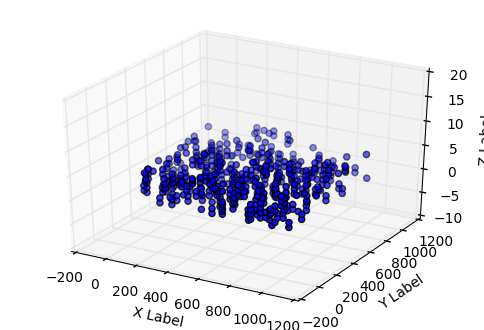

523
[[   3  221    0]
 [   3  555    0]
 [   7  929    0]
 ..., 
 [ 999  471    5]
 [1016  368    5]
 [1019  254    5]]


In [150]:
"""Plot blobs from many planes"""
y,x,z = blobsList.T


#print z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim([-10,20])

plt.show()

# print len(blobsList)
# print blobsList


In [156]:
"""3D clustering of Blobs"""

db = DBSCAN(eps=2, min_samples=2).fit(blobsList)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(blobsList, labels))

#print labels
#print db.components_
#print db.core_sample_indices_ 

"""Group up the dots within a cluster"""
###  [[[cluster1_1],[cluster1_2],...],
#     [[cluster2_1],[cluster2_2]...],
#     [...],...,
#     [[clusterN_1],[clusterN_2]]]
#

#print labels
#print db.components_
clusters=[]

#print len(db.components_)
#print db.components_[99]
#print blobsList[0]
#print blobsList[99]

for i in range(n_clusters_):
    cluster=[]
    ## Extract X,Y,Z location of the points based on clusters
    positions=np.argwhere(labels==i)
    for j in range(len(positions)):
        cluster.append(blobsList[positions[j]])
    clusters.append(cluster)


Estimated number of clusters: 162
Silhouette Coefficient: 0.407


In [ ]:
"""VISUALIZE the CLUSTERS"""
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = blobsList[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = blobsList[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [261]:
"""Find the actual signal location"""
signals=[]
for i in range(len(clusters)):
    signal=[]
    dots=[]
    ## extract the intensity of the dot in the cluster (from the dictionary)
    for j in range(len(clusters[i])):
        #print clusters[i][j][0]
        dot=clusters[i][j][0]
        intensity=blobs["{},{},{}".format(clusters[i][j][0][0],clusters[i][j][0][1],clusters[i][j][0][2])][1]
        dot=np.append(dot,intensity)
        dots.append(dot)
    
    #print dots
    
    # Calculating the actual dot location
    intensity_sum=sum(dots[index][3] for index in range(len(dots)))
    avgIntensity=intensity_sum/len(dots)
    y=sum(dots[index][0]*dots[index][3]/intensity_sum for index in range(len(dots)))
    x=sum(dots[index][1]*dots[index][3]/intensity_sum for index in range(len(dots)))
    z=sum(dots[index][2]*dots[index][3]/intensity_sum for index in range(len(dots)))
    
    signal=[y,x,z,avgIntensity]
    signals.append(signal)

#print len(signals)
#print signals
#print blobs

